In [1]:
import torch
import torch.nn.functional as F
import torchmetrics

import sys
sys.path.insert(0, '/home/maria/py/dl/my_d2l')
from my_package import preData, fig, hdc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. 加载数据集 MNIST

Number of batches in train_loader: 235
Number of batches in test_loader: 40
Shape of each sample (features): torch.Size([1, 28, 28])
Shape of each label: torch.Size([])
Data type of sample and label:  torch.float32 torch.int64
Number of classes: 10
torch.Size([256, 1, 28, 28])


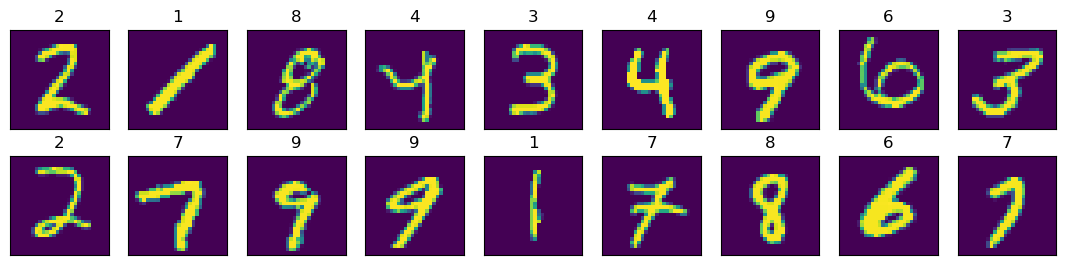

In [2]:
dataset_path = "../../data"
batch_size = 256
train_iter, test_iter = preData.load_data_mnist(path=dataset_path, batch_size=batch_size)

# 2. 定义编码映射和训练

position -> random_vec,
value -> level_vec

对二进制{0, 1}，
bind(pos, value) === pos ^ value

In [3]:
def quant(hv, thre, datatype='binary'):
    """
    Function
    ===
    Quantinize the element in the HV. 
    Range > thre and <= thre

    Parameter
    ---
    `data type`: the element is within 
    'bipolar' {-1, 1}
    'binary' {0, 1}
    """
    if datatype == 'bipolar':
        return torch.where(hv > thre, torch.ones_like(hv, dtype=torch.int8),
                           torch.full_like(hv, -1, dtype=torch.int8))
    elif datatype == 'binary':
        return torch.where(hv > thre, torch.ones_like(hv, dtype=torch.int8),
                           torch.full_like(hv, 0, dtype=torch.int8))
    else:
        raise ValueError('Sorry, not supporting datatype.')

In [4]:
def encode(img, pos, val, if_quant, datatype='binary'):
    """
    Function
    ===
    Encode all the pixels in an image using pos&val IM.

    Parameter
    ----
    Reshape the size (1, 28, 28) to one-dimension
    Quantize the image data(represented in float [0, 1)) to [0, 256).
    img: 一个包含像素值的一维张量
    pos: 一个包含位置向量的二维张量，shape 为 (img_size, vector_size)
    val: 一个包含值向量的二维张量，shape 为 (num_values, vector_size)
    
    Return
    ---

    """
    img = torch.round(img.reshape(-1) * 255).to(torch.int32)

    # 获取 img 中每个像素值对应的索引
    pos_indices = torch.arange(len(img)).unsqueeze(1)  # shape: (len(img), 1)
    pixel_indices = img.unsqueeze(1)  # shape: (len(img), 1)

    # 使用高级索引获取 pos 和 val 中对应的向量
    pos_vectors = pos[pos_indices]  # shape: (len(img), vector_size)
    val_vectors = val[pixel_indices]  # shape: (len(img), vector_size)

    # 对获取的向量进行 bind 操作
    # (-1, 1) *
    # (0, 1) ^
    if datatype == 'bipolar':
        img_hv = pos_vectors * val_vectors  # shape: (len(img), vector_size)
    elif datatype == 'binary':
        img_hv = pos_vectors ^ val_vectors  # shape: (len(img), vector_size)
    else:
        raise ValueError('Sorry, not supporting datatype.')

    img_hv = img_hv.sum(dim=0)
    if if_quant:
        return quant(img_hv[0], thre=28*14, datatype=datatype)
    else:
        return img_hv[0]

In [5]:
def predict(AM, img, pos_IM, val_IM, if_quant, datatype='binary'):
    """
    Function
    ===
    predict the class of the img according to memory
    First, encode the img to generate the query HV.
    Then compare the query HV with all the entry in AM and find the maximum index.
    """
    query_hv = encode(img, pos_IM, val_IM, if_quant, datatype=datatype)
    simi = F.cosine_similarity(query_hv.float(), AM.float())

    max_index = torch.argmax(simi).item()
    return max_index

def test(accuracy, AM, X_test, Y_test, pos_IM, val_IM, if_quant, datatype='binary'):
    """
    Function
    ===
    For each sample in the test dataset, predict the result.
    The overall result is converted to tensor and compared with label.
    """
    Y_pred = []
    for sample in X_test:
        Y_pred.append(predict(AM, sample, pos_IM, val_IM, if_quant, datatype=datatype))
    Y_pred = torch.tensor(Y_pred).to(device)
    accuracy.update(Y_test, Y_pred)

In [6]:
def train_epoch(AM, X_train, Y_train, pos_IM, val_IM, if_quant=False, datatype='binary'):
    """
    Function
    ===
    For each image in the sample, encode the pixel and position, add to AM.
    Quantinize according to image size.

    After summing up all the samples in one batch, quantinize according to popcount.

    """
    for img, label in zip(X_train, Y_train):
        AM[label] += encode(img, pos_IM, val_IM, if_quant=if_quant, datatype=datatype)


In [15]:
def train(AM, train_iter, test_iter, pos_IM, val_IM, num_classes, if_quant=False, datatype='binary'):
    test_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes).to(device)

    popcount = torch.zeros(AM.shape[0])

    num_epochs = len(train_iter)
    animator = fig.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['test acc'])

    epoch = 0
    for sample, label in train_iter:
        sample, label = sample.to(device), label.to(device)
        train_epoch(AM=AM, X_train=sample, Y_train=label,
                pos_IM=pos_IM, val_IM=val_IM, if_quant=if_quant, datatype=datatype)
        if if_quant:
            for l in label:
                popcount[l] += 1
        print(AM, popcount)

        # test on one batch
        for test_s, test_l in test_iter:
            test_s, test_l = test_s.to(device), test_l.to(device)
            test(accuracy=test_accuracy, AM=AM, X_test=test_s, Y_test=test_l,
                pos_IM=pos_IM, val_IM=val_IM, if_quant=if_quant, datatype=datatype)
            break

        animator.add(epoch+1, (test_accuracy.compute().item()))
        fig.plt.show()
        epoch += 1
        if epoch == 64:
            break

    if if_quant:
        AM[:] = torch.stack([quant(vec, thre=popcount[i]//2, datatype=datatype) for i, vec in enumerate(AM)])
    print(AM, popcount.sum())

# 3. 参数和 HV 初始化

In [16]:
dim = 4096
datatype = 'binary' # 'binary' {0, 1} 'bipolar' {-1, 1}
operation = 'MAP'

img_size = 28 * 28 # size of MNIST image
img_gray_val = 256 # maximum gray scale of MNIST image
num_class = 10 # number of classes inside MNIST dataset

生成 position 即坐标位置的 IM 和每个像素值的 IM
初始化每个类的 AM

In [17]:
if_quant = True
position_IM = hdc.item_memory(dim=dim, number=img_size, datatype=datatype)
grayscale_IM = hdc.item_memory(dim=dim, number=img_gray_val, datatype=datatype)     

AM = torch.zeros(size=(num_class, dim), dtype = torch.int32)
position_IM, grayscale_IM, AM = position_IM.to(device), grayscale_IM.to(device), AM.to(device)

# 4. train and interfere

In [18]:
train(AM=AM, train_iter=train_iter, test_iter=test_iter,
      pos_IM=position_IM, val_IM=grayscale_IM, num_classes=num_class,
      if_quant=if_quant, datatype=datatype)

tensor([[1, 1, 0,  ..., 0, 1, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        ...,
        [1, 1, 0,  ..., 0, 1, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        [1, 1, 0,  ..., 0, 1, 0]], device='cuda:0', dtype=torch.int32) tensor(16384.)


In [19]:
from rich.progress import track
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

for sample, label in track(test_iter, description="Testing"):
    sample, label = sample.to(device), label.to(device)
    test(accuracy, AM, X_test=sample, Y_test=label,
         pos_IM=position_IM, val_IM=grayscale_IM, if_quant=if_quant, datatype=datatype)
print(f"Dimension {dim}: Test accuracy is {(accuracy.compute().item() * 100):.3f}%")

Output()

Dimension 4096: Test accuracy is 76.170%


array([<Axes: title={'center': '7'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '8'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '7'}>],
      dtype=object)

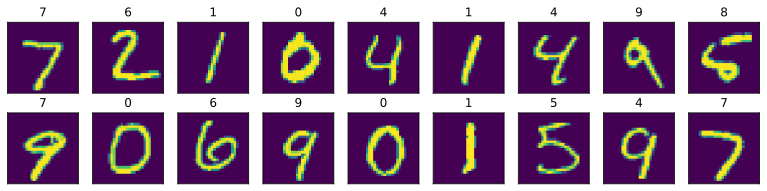

In [20]:
X, y = next(iter(test_iter))
Y_pred = []
for sample in X:
    Y_pred.append(predict(AM, sample, position_IM, grayscale_IM, if_quant, datatype=datatype))
Y_pred = torch.tensor(Y_pred)
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_mnist_labels(Y_pred))